In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Charger les données
df = pd.read_csv("features_log.csv")

# Afficher un aperçu
df.head()


,timestamp,gaze,mean_x_l,mean_y_l,std_x_l,std_y_l,maxdev_x_l,maxdev_y_l,mean_x_r,mean_y_r,std_x_r,std_y_r,maxdev_x_r,maxdev_y_r,anomaly
0,2025-07-07 03:28:10,Center,320.533333,312.316667,1.936205,2.486575,6.533333,5.683333,397.516667,306.283333,2.140807,2.422751,6.516667,4.716667,No
1,2025-07-07 03:28:10,Center,320.466667,312.233333,2.085399,2.445177,6.466667,5.766667,397.416667,306.166667,2.340169,2.409472,7.416667,4.833333,No
2,2025-07-07 03:28:10,Center,320.350000,312.133333,2.343964,2.369716,8.350000,5.866667,397.333333,306.033333,2.507766,2.359143,7.333333,4.966667,No
3,2025-07-07 03:28:10,Center,320.233333,312.033333,2.571424,2.287405,8.233333,5.966667,397.250000,305.900000,2.662236,2.300000,7.250000,5.100000,No
4,2025-07-07 03:28:10,Center,320.133333,311.900000,2.765662,2.165641,8.133333,5.100000,397.166667,305.766667,2.805748,2.231342,7.166667,4.233333,No


In [4]:
import pandas as pd
import numpy as np

# Charger les données
df = pd.read_csv("features_log.csv")

# Sélectionner les colonnes utiles (exemple avec 4 features)
features = df[["mean_x_l", "mean_y_l", "mean_x_r", "mean_y_r"]].values

# Définir la longueur des séquences (60 frames)
seq_length = 60

# Créer les séquences
n_sequences = len(features) - seq_length + 1
sequences = np.array([features[i:i+seq_length] for i in range(n_sequences)])

print(f"Forme des séquences : {sequences.shape}")


Forme des séquences : (4830, 60, 4)


Nombre de séquences : 4830


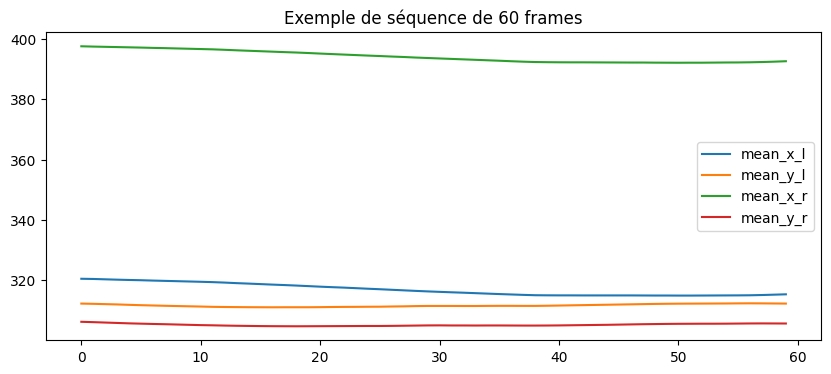

In [5]:
# Colonnes features
feature_cols = ["mean_x_l", "mean_y_l", "mean_x_r", "mean_y_r"]
data = df[feature_cols].values

# Créer des séquences glissantes de 60 frames
sequence_length = 60
sequences = []
for i in range(len(data) - sequence_length + 1):
    seq = data[i:i+sequence_length]
    sequences.append(seq)
sequences = np.array(sequences)
print(f"Nombre de séquences : {sequences.shape[0]}")

# Affichage d’une séquence exemple
plt.figure(figsize=(10,4))
plt.plot(sequences[0][:,0], label='mean_x_l')
plt.plot(sequences[0][:,1], label='mean_y_l')
plt.plot(sequences[0][:,2], label='mean_x_r')
plt.plot(sequences[0][:,3], label='mean_y_r')
plt.legend()
plt.title("Exemple de séquence de 60 frames")
plt.show()


In [6]:
n_samples, timesteps, n_features = sequences.shape
sequences_reshaped = sequences.reshape(-1, n_features)
scaler = StandardScaler()
sequences_scaled = scaler.fit_transform(sequences_reshaped)
sequences_scaled = sequences_scaled.reshape(n_samples, timesteps, n_features)

X_train, X_test = train_test_split(sequences_scaled, test_size=0.2, random_state=42)
print(f"Taille train: {X_train.shape}, taille test: {X_test.shape}")


Taille train: (3864, 60, 4), taille test: (966, 60, 4)


In [7]:
inputs = Input(shape=(timesteps, n_features))
encoded = Bidirectional(LSTM(64, return_sequences=True))(inputs)
encoded = Dropout(0.2)(encoded)
encoded = Bidirectional(LSTM(32))(encoded)
encoded = Dropout(0.2)(encoded)
encoded = Dense(16, activation='relu')(encoded)
decoded = RepeatVector(timesteps)(encoded)
decoded = Bidirectional(LSTM(32, return_sequences=True))(decoded)
decoded = Dropout(0.2)(decoded)
decoded = Bidirectional(LSTM(64, return_sequences=True))(decoded)
decoded = Dropout(0.2)(decoded)
outputs = TimeDistributed(Dense(n_features))(decoded)

autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 60, 128)        │        35,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 60, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 60, 64)         │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 60, 128)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 60, 4)          │           516 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,692 (612.08 KB)

 Trainable params: 156,692 (612.08 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 30s 298ms/step - loss: 0.4097 - val_loss: 0.0742
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - loss: 0.0971 - val_loss: 0.0578
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - loss: 0.0795 - val_loss: 0.0466
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 244ms/step - loss: 0.0642 - val_loss: 0.0346
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 236ms/step - loss: 0.0548 - val_loss: 0.0289
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - loss: 0.0514 - val_loss: 0.0217
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - loss: 0.0400 - val_loss: 0.0223
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 232ms/step - loss: 0.0396 - val_loss: 0.0175
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - loss: 0.0369 - val_loss: 0.0157
Epoch 10/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 228ms/step - loss: 0.0331 - val_loss: 0.0178
Epoch 11/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.0308 - val_loss: 0.0160
Epoch 12/100
61/61 ━━━━━━━━━━━

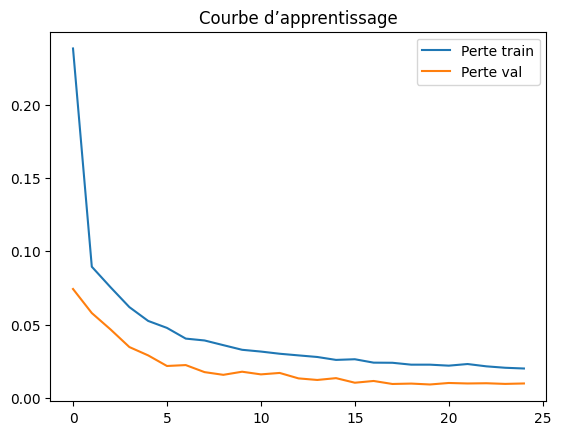

In [8]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_test, X_test),
    callbacks=[early_stop]
)

plt.plot(history.history['loss'], label='Perte train')
plt.plot(history.history['val_loss'], label='Perte val')
plt.legend()
plt.title("Courbe d’apprentissage")
plt.show()


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step
Nombre d'anomalies détectées : 49


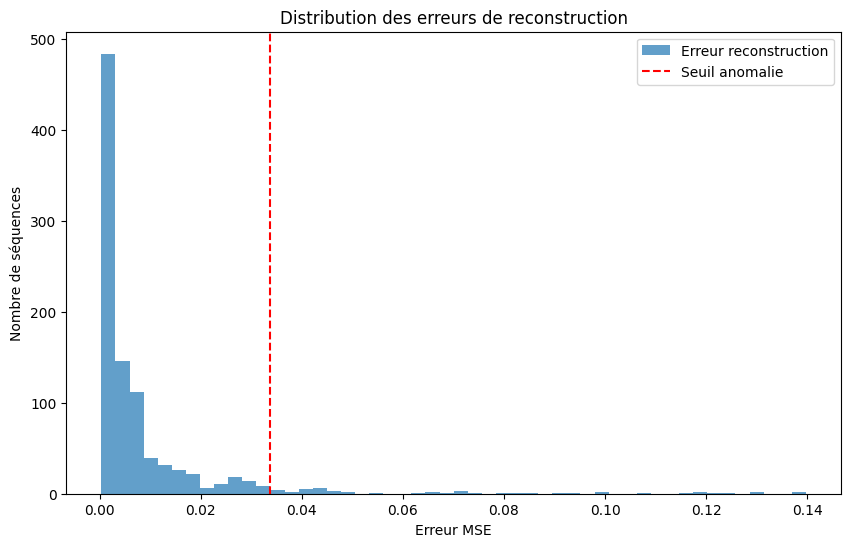

In [9]:
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=(1,2))
threshold = np.percentile(mse, 95)
anomalies = mse > threshold

print(f"Nombre d'anomalies détectées : {np.sum(anomalies)}")

plt.figure(figsize=(10,6))
plt.hist(mse, bins=50, alpha=0.7, label='Erreur reconstruction')
plt.axvline(threshold, color='r', linestyle='--', label='Seuil anomalie')
plt.legend()
plt.title("Distribution des erreurs de reconstruction")
plt.xlabel("Erreur MSE")
plt.ylabel("Nombre de séquences")
plt.show()
